In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
# Sets the pandas dataframe options to display all columns/ rows.
pd.options.display.max_rows = None

In [3]:
# Load preprocessed data

loan_data_preprocessed_backup = pd.read_pickle('loan_data_2007_2014_preprocessed.pkl')

In [4]:
# Sanity check
loan_data_preprocessed_backup.shape

(466285, 207)

In [5]:
# Sanity check
loan_data_preprocessed_backup.head()


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,0,0,0,0,0,0,0,0,1,0
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,0,0,0,0,0,0,0,0,1,0
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,0,0,0,0,0,0,0,0,1,0
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,0,0,0,0,0,0,0,0,1,0
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,0,0,0,0,0,0,0,0,1,0


In [6]:
# Sanity check

loan_data_preprocessed_backup.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [7]:
# Make a copy and work on the copy. A good habit in ML

loan_data_preprocessed = loan_data_preprocessed_backup.copy()

In [8]:
# Sanity check
loan_data_preprocessed.shape

(466285, 207)

# LGD and EAD models

These models should be build only on accounts have been written off.



In [9]:
loan_data_preprocessed['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

From the list above, we will use the following 2 values to identify defaulted loans

'Charged Off'

'Does not meet the credit policy. Status:Charged Off'



In [10]:
# Load accounts  that have been written off into a dataframe

loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]


In [11]:
# check
loan_data_defaults.shape

(43236, 207)

In [12]:
loan_data_defaults.isnull().sum()

Unnamed: 0                                                             0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                                          2337
home_ownership                                     

There are missing values in several variables but we are going to use the following variables having missing values

mths_since_last_delinq                                             23950

mths_since_last_record                                             37821


Note: when we used these variables for PD model we used a dummy variable because with a PD model we have to build a model that can be easily understood.

With EAD and LGD models we are not restricted to dummy variables.

Therefore, we can impute the missing values

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Impute missing values using IterativeImputer (MICE)
imputer = IterativeImputer(random_state=42)
loan_data_defaults[['mths_since_last_delinq', 'mths_since_last_record']] = imputer.fit_transform(loan_data_defaults[['mths_since_last_delinq', 'mths_since_last_record']])

C:\Users\engrd\AppData\Local\Temp\ipykernel_8632\254375575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults[['mths_since_last_delinq', 'mths_since_last_record']] = imputer.fit_transform(loan_data_defaults[['mths_since_last_delinq', 'mths_since_last_record']])


In [14]:
# Check if missing values are filled
print(loan_data_defaults[['mths_since_last_delinq', 'mths_since_last_record']].isnull().sum())

mths_since_last_delinq    0
mths_since_last_record    0
dtype: int64


# Dependent variable for LGD model (recovery_rate)

LGD stands for loss given default

It is the % of the total exposure (total loan) that cannot be recovered once a default has occured

In practice, % of total loan (total exposure) that can be recovered is computed. This is called recovery rate

recovery_rate = recoveries / total_funded_amt

Therefore LGD = 1 - recovery_rate

In [15]:
# Compute recovery_rate

loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

C:\Users\engrd\AppData\Local\Temp\ipykernel_8632\1704475752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']


In [16]:
# Sanity check

loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [17]:
# Check how many samples have a recovery rate > 1. This seems to be a data issue
loan_data_defaults[loan_data_defaults['recovery_rate'] > 1].shape

(27, 208)

Since the number of samples with recovery_rate > 1 is only 27. I will just set the recovery_rate > 1 to 1.

In [18]:
# Set recovery rates that are greater than 1 to 1 and recovery rates that are less than 0 to 0.
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


C:\Users\engrd\AppData\Local\Temp\ipykernel_8632\1083912664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
C:\Users\engrd\AppData\Local\Temp\ipykernel_8632\1083912664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


In [19]:
# Sanity check
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

# Dependent variable for EAD model (credit_conversion_factor)

EAD stands for exposure at default

It is the maximum value a lender will loose when a default occurs.

For home loan for example, a borrower would have generally paid back some of the principal before the default occurs.

The % that is unpaid is often called "credit conversion factor".

# EAD = total_funded_amt * credit_conversion_factor

credit_conversion_factor will be our depedent variable for EAD model

## Formula for credit_coversion_factor = (funded_amount - total_recovered_principal)/ funded_amount

In [20]:
# Compute dependent variable for the EAD model: credit conversion factor

# credit conversion factor is ratio of the difference of the total funded amount and princial repaid over total funcded amount

loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']


C:\Users\engrd\AppData\Local\Temp\ipykernel_8632\385892119.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']


In [21]:
#sanity check
loan_data_defaults['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [22]:
# Save the data to a pickle file

#loan_data_defaults.to_pickle('loan_data_defaults.pickle')

# Exploration of dependent variables for LGD and EAD models


In [23]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

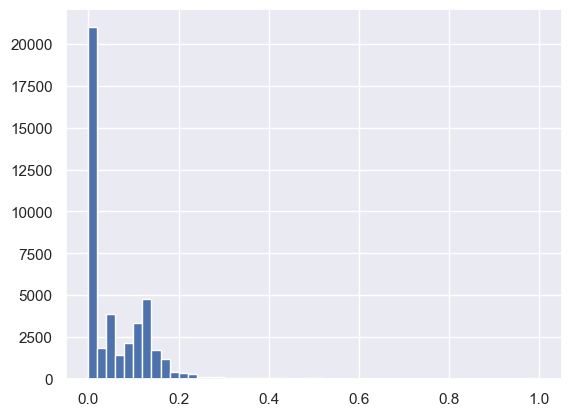

In [24]:
# Histogram with 50 bins
plt.hist(loan_data_defaults['recovery_rate'], bins = 50)

As seen above more than half of the values have a recovery_rate of 0.

So we can break this into 2 models.

1. Random Forest model to predict if recovery_rate is 0 or not.

2. Ridge Regression model to predict the value of recover_rate if Random Forest predicts that recovery_rate is not 0.


In [25]:
# create another column having 0 if recovery_rate is 0 and 1 otherwise.
# This will be the target of the Random Forest model described above

loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)


C:\Users\engrd\AppData\Local\Temp\ipykernel_8632\2800920223.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)


In [26]:
# sanity check
loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1].count()

Unnamed: 0                                                         24371
id                                                                 24371
member_id                                                          24371
loan_amnt                                                          24371
funded_amnt                                                        24371
funded_amnt_inv                                                    24371
term                                                               24371
int_rate                                                           24371
installment                                                        24371
grade                                                              24371
sub_grade                                                          24371
emp_title                                                          22638
emp_length                                                         23303
home_ownership                                     

In [27]:
loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 0].count()

Unnamed: 0                                                         18865
id                                                                 18865
member_id                                                          18865
loan_amnt                                                          18865
funded_amnt                                                        18865
funded_amnt_inv                                                    18865
term                                                               18865
int_rate                                                           18865
installment                                                        18865
grade                                                              18865
sub_grade                                                          18865
emp_title                                                          17311
emp_length                                                         17596
home_ownership                                     

## Plotting CCF which is dependent variable for EAD model

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

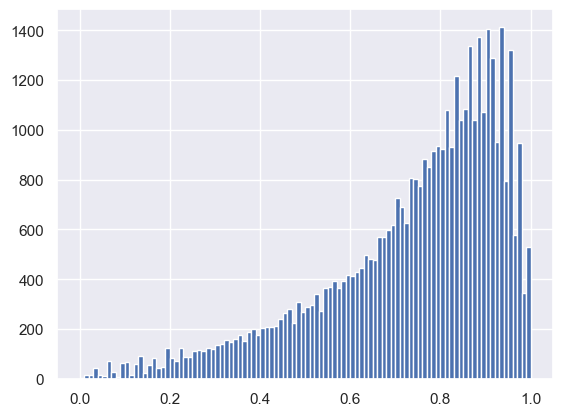

In [28]:
# Plot credit conversion factor into 50 bins

plt.hist(loan_data_defaults['CCF'], bins = 100)

We will use a lasso regression model to predict credit conversion factor directly.


# LGD Model



## Splitting into train and test sets

In [29]:
from sklearn.model_selection import train_test_split

## LGD Model stage 1 - Random Forest to predict recovery_rate 0 or 1.

if recovery_rate = 0 then we are done

else

if recovery rate !=0 then go to stage 2 model


In [30]:
# LGD model stage 1 datasets: recovery rate 0 or greater than 0.

lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)


In [31]:
# Sanity check

print (lgd_inputs_stage_1_train.shape)
print (lgd_inputs_stage_1_test.shape)
print (lgd_targets_stage_1_train.shape)
print (lgd_targets_stage_1_test.shape)

(34588, 207)
(8648, 207)
(34588,)
(8648,)


## Keep only required features for stage 1 model

In [32]:
# List containing all independent variables
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [33]:
# List containing reference variables
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [34]:
# Remove other variables
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]

lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]

In [35]:
# Remove reference variables like we did before
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [36]:
# Sanity check
# Check for missing values. 
lgd_inputs_stage_1_train.isnull().sum()

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

# Model training

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay

In [38]:
# Initialize and fit the Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

RandomForestClassifier(random_state=42)

In [39]:
# Get feature names
feature_names = lgd_inputs_stage_1_train.columns.values

In [40]:
# Create a dataframe for feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_classifier.feature_importances_})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)

                                Feature  Importance
28                   mths_since_issue_d    0.116732
34                                  dti    0.073381
29          mths_since_earliest_cr_line    0.069817
43                     total_rev_hi_lim    0.069257
32                          installment    0.068596
33                           annual_inc    0.066269
31                             int_rate    0.061962
41                            total_acc    0.060227
30                          funded_amnt    0.057442
39                             open_acc    0.048906
25                initial_list_status:w    0.039930
38               mths_since_last_record    0.039861
37               mths_since_last_delinq    0.039041
27                       emp_length_int    0.038398
36                       inq_last_6mths    0.026369
6               home_ownership:MORTGAGE    0.011514
13           purpose:debt_consolidation    0.010763
35                          delinq_2yrs    0.009754
11  verifica

# Model Testing

In [41]:
lgd_inputs_stage_1_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [42]:
lgd_inputs_stage_1_train.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [43]:
# Predict on the test set
y_pred_stage_1 = rf_classifier.predict(lgd_inputs_stage_1_test)

In [44]:
# Predict probabilities instead of just the class
y_pred_proba_stage_1 = rf_classifier.predict_proba(lgd_inputs_stage_1_test)

In [45]:
# Extract probabilities for recovery_rate > 0
y_hat_test_proba_lgd_stage_1 = y_pred_proba_stage_1[:, 1]

In [46]:
# Create a new dataframe with all test samples
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test.reset_index(drop=True)
df_actual_predicted_probs = pd.DataFrame({
    'lgd_targets_stage_1_test': lgd_targets_stage_1_test_temp,
    'y_hat_test_proba_lgd_stage_1': y_hat_test_proba_lgd_stage_1
})

print(df_actual_predicted_probs.head())

   lgd_targets_stage_1_test  y_hat_test_proba_lgd_stage_1
0                         1                          0.44
1                         1                          0.49
2                         0                          0.64
3                         1                          0.44
4                         0                          0.43


In [47]:
# sanity check
df_actual_predicted_probs.shape

(8648, 2)

# Check performace of model


In [48]:
# Set threshold
tr = 0.5
# Compute predictions
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

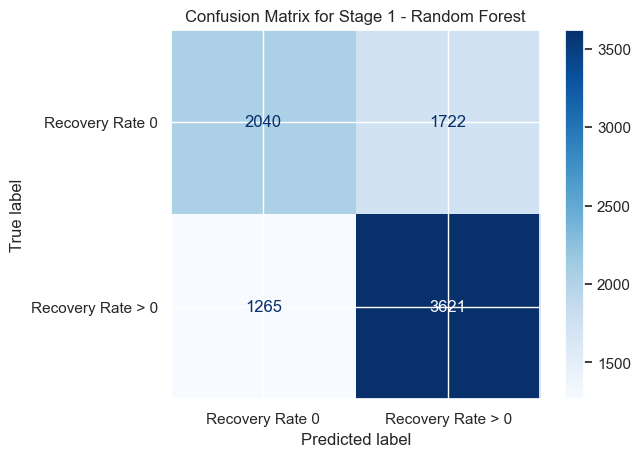

Confusion Matrix:
[[2040 1722]
 [1265 3621]]


In [49]:
# Confusion Matrix
cm = confusion_matrix(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Recovery Rate 0', 'Recovery Rate > 0'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Stage 1 - Random Forest')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [50]:
# Compute accuracy
accuracy = accuracy_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'])
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.65


In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Compute AUC ROC
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
print(f'AUC ROC: {AUROC:.2f}')

AUC ROC: 0.70


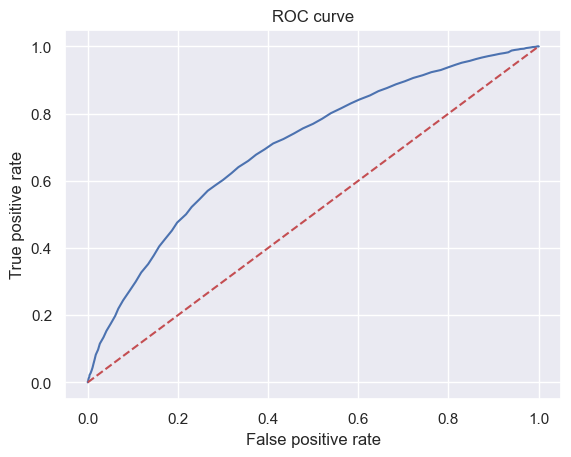

In [52]:
# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle='--', color='r')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [53]:
# Find best threshold
optimal_rate = tpr - fpr
optimal_idx = np.argmax(optimal_rate)
best_thresh = thresholds[optimal_idx]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.570000


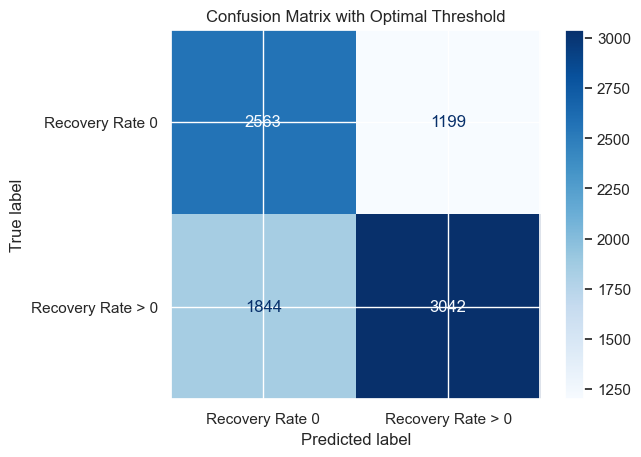

In [54]:
# Check the confusion matrix with the best threshold
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > best_thresh, 1, 0)
cm_optimal = confusion_matrix(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'])
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=['Recovery Rate 0', 'Recovery Rate > 0'])
disp_optimal.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with Optimal Threshold')
plt.show()

In [55]:
# Compute accuracy with optimal threshold
accuracy_optimal = accuracy_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'])
print(f'Accuracy with Optimal Threshold: {accuracy_optimal:.2f}')

Accuracy with Optimal Threshold: 0.65


## Save the stage 1 model 

So we can load it into any notebook we use to build stage 2 model



In [56]:
# Save the model
#with open('rf_classifier_model_lgd_stage_1.sav', 'wb') as f:
#    pickle.dump(rf_classifier, f)

In [57]:
import pickle

# Save the model
pickle.dump(rf_classifier, open('rf_classifier_model_lgd_stage_1.sav', 'wb'))

# Stage 2 model - Ridge regression
We will use this model on samples where stage 1 model predicts recovery_rate to be greater than 0.

In [58]:
# Keep on samples where recovery_rate = 1

lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [59]:
# 80-20 train test split with random_state = 42 

lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [60]:
# sanity check

print (lgd_inputs_stage_2_train.shape)

print (lgd_inputs_stage_2_test.shape)

print (lgd_targets_stage_2_train.shape)

print (lgd_targets_stage_2_test.shape)

(19496, 207)
(4875, 207)
(19496,)
(4875,)


In [61]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [62]:
# Keep only the feature we are going to use to train model

lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

# Remove dummy variable

lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)


In [63]:
from sklearn.linear_model import Ridge

# Create Ridge regression model object
reg_lgd_st_2 = Ridge(alpha=1.0)  # alpha is the regularization strength; larger values specify stronger regularization

# Fit data into the model
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)


Ridge()

In [64]:
# Stores the names of the columns of a dataframe in a variable.

feature_name = lgd_inputs_stage_2_train.columns.values

In [65]:
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)

# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)



In [66]:
# Increases the index of every row of the dataframe with 1.
summary_table.index = summary_table.index + 1

# Assigns values of intercept to the row with index 0 of the dataframe.
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]

# Sort dataframe by index

summary_table = summary_table.sort_index()


summary_table

,Feature name,Coefficients
0,Intercept,2.529928e-01
1,grade:A,-6.113079e-02
2,grade:B,-4.505502e-02
3,grade:C,-3.292870e-02
4,grade:D,-2.369571e-02
5,grade:E,-1.094129e-02
6,grade:F,-3.987334e-03
7,home_ownership:MORTGAGE,2.957967e-03
8,home_ownership:NONE,1.216237e-01
9,home_ownership:OTHER,-7.030572e-03


# Stage 2 model evaluation

In [67]:
#  Keep only the variables we need for the model.

lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]


In [68]:
# Remove the dummy variable reference categories.

lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)


In [69]:
# Use trained model to predict

y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)


In [70]:
# Sanity check

y_hat_test_lgd_stage_2.shape

(4875,)

In [71]:
# Create copy of dataframe containing test targets and reset its index
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test
lgd_targets_stage_2_test_temp.reset_index(drop=True, inplace=True)
lgd_targets_stage_2_test_temp.head()

0    0.033254
1    0.156128
2    0.181260
3    0.035356
4    0.046756
Name: recovery_rate, dtype: float64

In [72]:
# Concatenate the 2 dataframes
df = pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1)
# compute correlation

df.corr()

,recovery_rate,0
recovery_rate,1.000000,0.306762
0,0.306762,1.000000


C:\Users\engrd\AppData\Local\Temp\ipykernel_8632\422630056.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)


<Axes: xlabel='recovery_rate', ylabel='Density'>

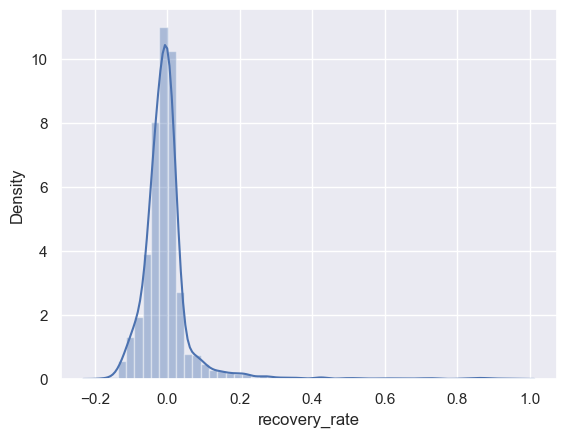

In [73]:
# Check residuals
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)

The residuals are normally distributed around mean of 0.0

This means that the errors are not correlated or systematic.



In [74]:
# Save stage 2 model

pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2.sav', 'wb'))

# Combining stage 1 and stage 2 to create final LGD model

In [75]:
# predict on all test samples using stage 2 model

y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [76]:
# check
y_hat_test_lgd_stage_2_all.shape

(8648,)

We use stage 2 prediction for samples for which stage 1 predicts 1 i.e recovery_rate > 1

If stage 1 predicts 0 i.e recovery_rate = 0 then we can ignore the prediction of stage 2 model



In [77]:
# multiply predictions of stage 1 and stage 2 element
# when stage 1 predicts 0 the final output will 0 * (stage 2 prediction) = 0


y_hat_test_lgd = y_hat_test_proba_lgd_stage_1 * y_hat_test_lgd_stage_2_all


In [78]:
# check
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.060461
std,0.017728
min,-0.001674
25%,0.049411
50%,0.060870
75%,0.071950
max,0.272719


In [79]:
# The min value is less than 0 so replace it with 0
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)


# EAD Model



In [80]:
# Data for EAD model. 
# Drop 'good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF' 
# 'CCF' is the target

ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)


In [81]:
#check

ead_inputs_train.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [82]:
# Filter out the variables that wont be used by the model

ead_inputs_train = ead_inputs_train[features_all]

In [83]:
# Remove the reference category variables
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)


In [84]:
from sklearn.linear_model import Lasso
reg_ead = Lasso(alpha=0.1)
reg_ead.fit(ead_inputs_train, ead_targets_train)

Lasso(alpha=0.1)

In [85]:
# get feature names into a list
feature_name = ead_inputs_train.columns.values

In [86]:
# Build summary table for EAD model. Code is same as before the code used for lgd model

summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)

summary_table['Coefficients'] = np.transpose(reg_ead.coef_)




In [87]:
summary_table

,Feature name,Coefficients
0,grade:A,-0.000000e+00
1,grade:B,-0.000000e+00
2,grade:C,-0.000000e+00
3,grade:D,0.000000e+00
4,grade:E,0.000000e+00
5,grade:F,0.000000e+00
6,home_ownership:MORTGAGE,-0.000000e+00
7,home_ownership:NONE,-0.000000e+00
8,home_ownership:OTHER,0.000000e+00
9,home_ownership:OWN,0.000000e+00


In [88]:
# Add intercept and reset indexes 
summary_table.index = summary_table.index + 1

summary_table.loc[0] = ['Intercept', reg_ead.intercept_]

summary_table = summary_table.sort_index()


In [89]:
# Check
summary_table

,Feature name,Coefficients
0,Intercept,7.365398e-01
1,grade:A,-0.000000e+00
2,grade:B,-0.000000e+00
3,grade:C,-0.000000e+00
4,grade:D,0.000000e+00
5,grade:E,0.000000e+00
6,grade:F,0.000000e+00
7,home_ownership:MORTGAGE,-0.000000e+00
8,home_ownership:NONE,-0.000000e+00
9,home_ownership:OTHER,0.000000e+00


## Interpretation of the co-efficients

A postive coefficient implies an increase in the Credit conversion factor (CCF)

A negative coefficient implies a decrease in the credit conversion factor (CCF)

Remember, credit conversion factor is the % of the loan that is still outstanding when the borrower defaults.

Therefore, higher CCF implies higher risk while a lower CCF implies lower risk.


A borrower with grade:A has a 30% lower CCF as compared to a borrower having grade:G which is the reference category for grade).

For contionous features, such as int_rate for a unit increase in int_rate, the CCF will decrease by 1.17%.




## Model testing


In [90]:
# remove features not used to train the model
ead_inputs_test = ead_inputs_test[features_all]

In [91]:
# check
features_reference_cat

['grade:G',
 'home_ownership:RENT',
 'verification_status:Verified',
 'purpose:credit_card',
 'initial_list_status:f']

In [92]:
#check
ead_inputs_test.columns

Index(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'grade:G', 'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN', 'home_ownership:RENT',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'verification_status:Verified',
       'purpose:car', 'purpose:credit_card', 'purpose:debt_consolidation',
       'purpose:educational', 'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy', 'purpose:small_business',
       'purpose:vacation', 'purpose:wedding', 'initial_list_status:f',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'o

In [93]:
# remove categorical features for discrete features
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)


In [94]:
# check
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [95]:
# Predict
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [96]:
# Create a new variable containing test samples

ead_targets_test_temp = ead_targets_test

# reset index of new dataframe

ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [97]:
# Compute coorelation between the actual and predicted values

pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()


,CCF,0
CCF,1.000000,0.488888
0,0.488888,1.000000


0.4888 is a moderately strong correlation which is a good thing.

If actual values and predicted values were too strongly coorelated then the model is likely to be wrong.



C:\Users\engrd\AppData\Local\Temp\ipykernel_8632\4002925658.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ead_targets_test - y_hat_test_ead)


<Axes: xlabel='CCF', ylabel='Density'>

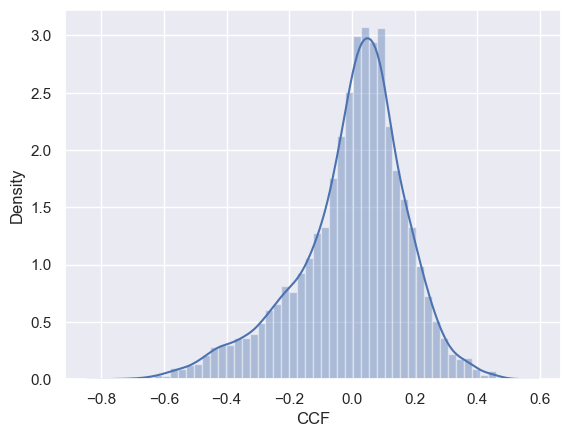

In [98]:
# Check distirbution of residuals

sns.distplot(ead_targets_test - y_hat_test_ead)


The residuals are distributed symmetrically and are symmetric around a mean of 0 which is a good thing.


In [99]:
pd.DataFrame(y_hat_test_ead).describe()


,0
count,8648.000000
mean,0.735845
std,0.085925
min,0.441053
25%,0.687027
50%,0.727679
75%,0.804631
max,0.907427


Note: CCF lies in between 0 and 1 for linear regression model but for lasso regression it is not a problem.

In [100]:
# Save the EAD model

pickle.dump(reg_ead, open('ead_model_.sav', 'wb'))